## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
import matplotlib.pyplot as plt

## Load data

In [5]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

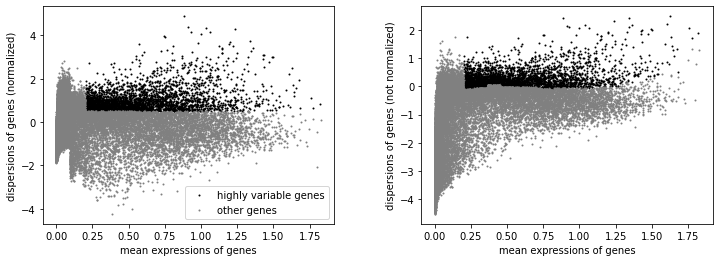

2944

In [6]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

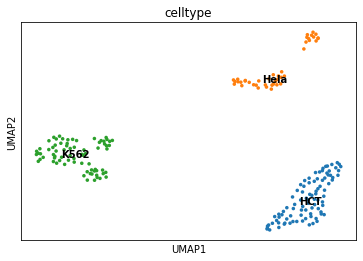

In [7]:
# Umap
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50)

## Preprocess ATAC

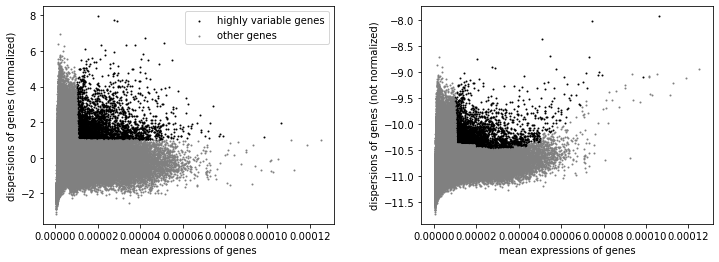

3307

In [8]:
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

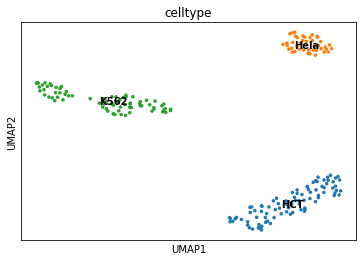

In [9]:
# Umap
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50)

## OT NMF

In [166]:
eps = .05
latent_dim = 10
rho = .08

In [167]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho, rho_w=rho, lr=1e-2, eps=eps)

In [168]:
nmf.fit_transform(mdata, cost='cosine', n_iter_inner=20, n_iter=10, device='cpu')

 70%|███████   | 560/800 [01:47<00:48,  4.96it/s]

## Convergence plots

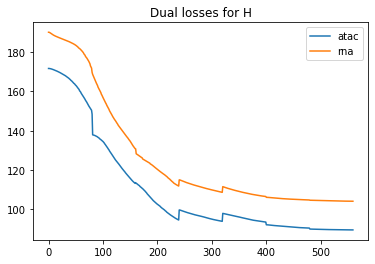

 70%|███████   | 560/800 [01:47<00:46,  5.20it/s]


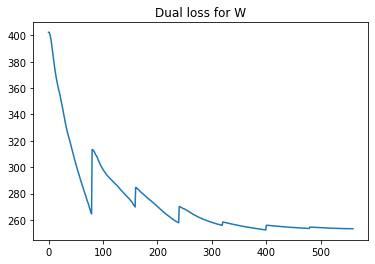

In [169]:
plt.title('Dual losses for H')
for mod in mdata.mod:
    plt.plot(nmf.losses_h[mod])
plt.legend(mdata.mod.keys())
plt.show()

plt.title('Dual loss for W')
plt.plot(nmf.losses_w)
plt.show()

## Viz

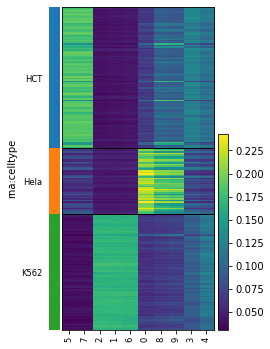

In [170]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

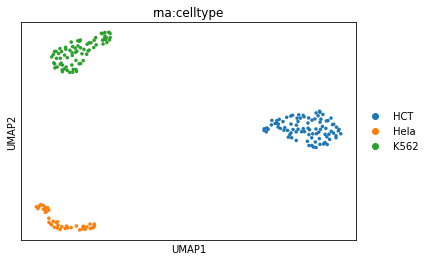

In [171]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Variance explained

experimental, i have to test this function


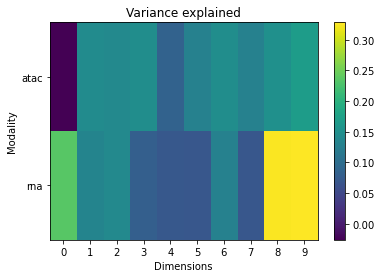

In [172]:
tl.variance_explained(mdata);

## Clustering

In [184]:
reload(tl)

<module 'scmiot.tl' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/tl.py'>

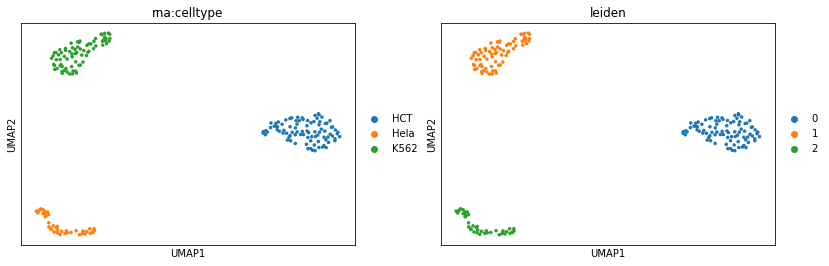

In [185]:
tl.leiden(mdata, resolution=.01)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])

## Clustering with automatic resolution

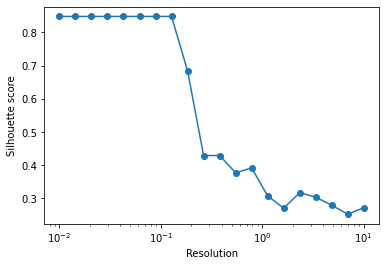

Leiden with best resolution heuristic (second local maximum silhouette): 0.37926901907322497


In [186]:
res = tl.best_leiden_resolution(mdata)
print('Leiden with best resolution heuristic (second local maximum silhouette):', res)

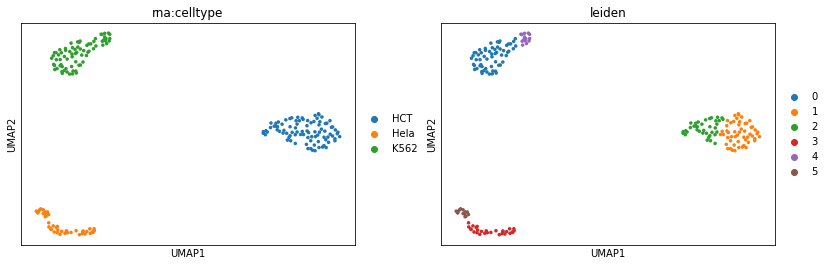

In [187]:
tl.leiden(mdata, resolution=res)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])